# Sequential Feature Selection

In [92]:
import pandas as pd
import numpy as np


df_bcf = pd.read_csv("https://raw.githubusercontent.com/edgarsmdn/MLCE_book/main/references/BCF_training.csv")

df_bcf.head()

,CAS,SMILES,Experimental value [log(L/kg)],NumAromaticRings,NumHAcceptors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,fr_COO,fr_COO2,fr_halogen,MolWt,MolLogP
0,50-29-3,c1cc(ccc1C(c2ccc(cc2)Cl)C(Cl)(Cl)Cl)Cl,3.605,2,0,5,2,100,0.540334,0.00,85.0370,2.474117,494.044161,0,0,5,354.491,6.4955
1,50-30-6,O=C(O)c1c(cccc1Cl)Cl,-0.222,1,1,4,1,58,0.740184,37.30,43.4213,3.318913,276.242090,1,1,2,191.013,2.6916
2,50-31-7,O=C(O)c1c(ccc(c1Cl)Cl)Cl,0.073,1,1,5,1,64,0.744344,37.30,48.4313,3.428931,335.668528,1,1,3,225.458,3.3450
3,50-32-8,c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45,2.731,5,0,0,0,92,0.243454,0.00,87.6520,2.230840,1069.721887,0,0,0,252.316,5.7372
4,51-28-5,O=[N+]([O-])c1ccc(O)c(c1)[N+](=O)[O-],0.052,1,5,7,2,68,0.548520,106.51,41.4156,3.267052,375.287402,0,0,0,184.107,1.2086


In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score as R2

## Dataset Preparation

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X, y = df_bcf.iloc[:, 3:].values, df_bcf.iloc[:, 2].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [95]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as MSE,r2_score as R2

model = KNeighborsRegressor(n_neighbors=5)

model.fit(X_train_std, y_train)

print('MSE_train:', MSE(y_train,model.predict(X_train)))
print('R2_train:', R2(y_train,model.predict(X_train)))
print('MSE_test:', MSE(y_test,model.predict(X_test)))
print('R2_test:', R2(y_test,model.predict(X_test)))

MSE_train: 2.2080624428749998
R2_train: -0.24141465919248084
MSE_test: 2.191513343
R2_test: -0.2546216866469089


## To understand how Sequential Feature selection works let's try Selecting the best 5 features for fixed k_neighbors using Scikit Learn

In [96]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS
sfs_forward = SFS(model,
          n_features_to_select=6,
          direction='forward',
          scoring='neg_mean_squared_error',
          n_jobs=-1,
          cv=5)
sfs_forward = sfs_forward.fit(X_train_std, y_train)
X_train_std_transformed = sfs_forward.transform(X_train_std)
X_test_std_transformed = sfs_forward.transform(X_test_std)
model_transformed = KNeighborsRegressor(n_neighbors=5)
model_transformed.fit(X_train_std_transformed, y_train)
# print('MSE_test_transformed:', i, MSE(y_test,model_transformed.predict(X_test_std_transformed)))
print('R2_test_transformed:', R2(y_test,model_transformed.predict(X_test_std_transformed)))
selected_features = sfs_forward.get_support()

R2_test_transformed: 0.7866219221290096


## Rigorous features as well as k_neighbor search

In [97]:
#TRY YOURSELF

#### **Gaussian Process using Numpy**

#### Defining kernel

In [98]:
def kernel(x1,x2,l=1.0,sigma=1.0):
  d1 = (x1-x2.T)**2
  out = sigma*np.exp(-d1/(2+l**2))
  return out

#### Creating test set.

In [99]:
np.random.seed(0)
n = 40
x_test = np.linspace(-4,4,n).reshape(-1,1)

#### Prior Sampling

It is important to know following derived expresions for kernels to implement Gaussian process


*   k = kernel(x_train,x_train); explains similarities between training set among themselves
*   k_star = kernel(x_train,x_test); explains similarities between train and test set
*   k_star_star = kernel(x_test,x_test); explains similarities between test set among themselves
*   k_inverse = np.linalg.inv(k)



1.   m_post = k_star.T.dot(k_inverse).dot(y_train)          # mathematically defined predictions (mean) (see lecture slides)
2.   cov_post = k_star_star - k_star.T.dot(k_inverse).dot(k_star)   # mathematically defined covariance matrix (see lecture slides)
3.   std = np.sqrt(np.diag(cov_post)).reshape(m_post.shape)        # variance is always diagnol elements of covariance matrix




In [100]:
m = np.zeros(x_test.shape)
cov = kernel(x_test,x_test)   # k_star_star
prior_predictions = np.random.multivariate_normal(m.reshape(-1),cov,4)     #completely random without even knowing training data points)
print(prior_predictions.shape,x_test.shape)

(4, 40) (40, 1)


#### Plotting Prior Samples/Predictions

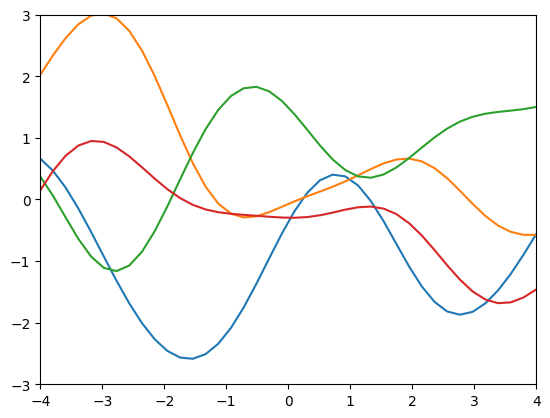

In [101]:
import matplotlib.pyplot as plt
plt.plot(x_test,prior_predictions.T)
plt.xlim(-4,4)
plt.ylim(-3,3)
plt.show()

#### Define training data

In [102]:
x_train = np.array([-3,-2,-1,1,2]).reshape(-1,1)
y_train = np.cos(x_train)
noise = 1e-07

#### Calculation of Posteriors

In [103]:
k = kernel(x_train,x_train)      # explains similarities between training set among themselves
k_star = kernel(x_train,x_test)  # explains similarities between train and test set
k_star_star = kernel(x_test,x_test)   # explains similarities between test set among themselves
k_inverse = np.linalg.inv(k)

#### Posteriors mean and covariance matrix



In [104]:
m_post = k_star.T.dot(k_inverse).dot(y_train)          # mathematically defined predictions (mean) (see lecture slides)
cov_post = k_star_star - k_star.T.dot(k_inverse).dot(k_star)   # mathematically defined covariance matrix (see lecture slides)
std = np.sqrt(np.diag(cov_post)).reshape(m_post.shape)        # variance is always diagnol elements of covariance matrix

#### Draw posterior samples/predictions



In [105]:
posterior_predictions = np.random.multivariate_normal(m_post.ravel(),cov_post,4)

#### Plotting Posterior Samples/Predictions

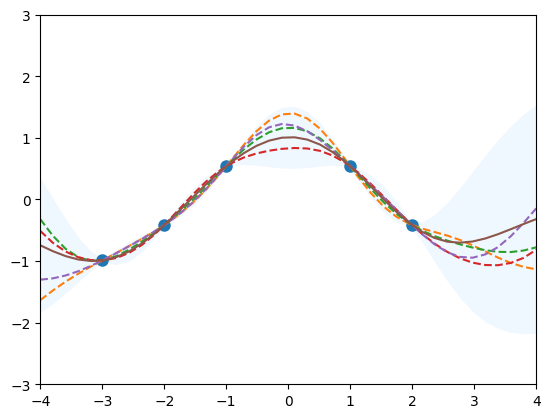

In [107]:
plt.plot(x_train,y_train,'o',ms=8)
plt.plot(x_test,posterior_predictions.T,'--')
plt.gca().fill_between(np.squeeze(x_test),np.squeeze(m_post - 1.96*std),np.squeeze(m_post + 1.96*std), color='aliceblue')
plt.plot(x_test,m_post)
plt.xlim(-4,4)
plt.ylim(-3,3)
plt.show()

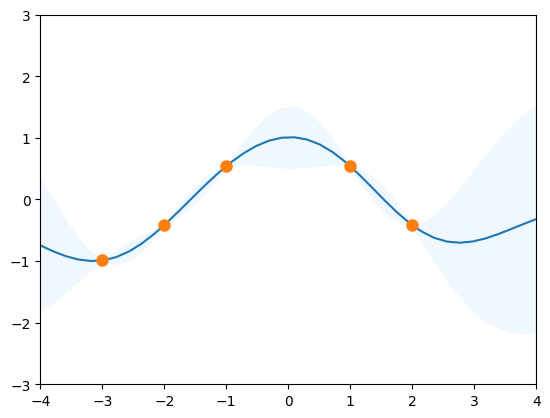

In [108]:
plt.gca().fill_between(np.squeeze(x_test),np.squeeze(m_post - 1.96*std),np.squeeze(m_post + 1.96*std), color='aliceblue')
plt.plot(x_test,m_post)
plt.plot(x_train,y_train,'o',ms=8)
plt.xlim(-4,4)
plt.ylim(-3,3)
plt.show()

#### **Gaussian Process using Scikit Learn**

In [109]:
from sklearn.gaussian_process import kernels, GaussianProcessRegressor
np.random.seed(0)
n = 40
kernel_ = [kernels.RationalQuadratic()]
# kernel_ = [kernels.RBF(),kernels.RationalQuadratic(),kernels.DotProduct(sigma_0=1.0)**2,kernels.RationalQuadratic()*kernels.Matern(),kernels.Matern()]


##################################################
RationalQuadratic(alpha=1, length_scale=1)
##################################################
gp.kernel_ :  RationalQuadratic(alpha=1e+05, length_scale=1.83)
gp.log_marginal_likelihood :  -3.908883932787954


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


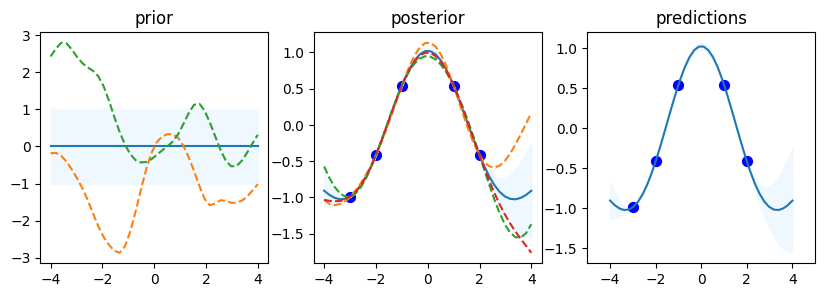

In [110]:
for kernel in kernel_:
  # implementation of Gaussian process
  gp = GaussianProcessRegressor(kernel = kernel,n_restarts_optimizer=2)

  # defining test set
  x_test = np.linspace(-4,4,n).reshape(-1,1)

  # prior sample/predictions
  m_prior, std_prior = gp.predict(x_test, return_std = True)
  prior_predictions = gp.sample_y(x_test,2)

  print('#'*50)
  print(kernel)
  print('#'*50)

  # plotting the prior_predictions/samples (initilaization)
  plt.figure(figsize = (10,3))
  plt.subplot(1,3,1)
  plt.plot(x_test,m_prior)
  plt.fill_between(x_test.ravel(),m_prior -std_prior, m_prior + std_prior, color = 'aliceblue')
  plt.plot(x_test,prior_predictions, '--')
  plt.title('prior')

  # defining training dataset
  x_train = np.array([-3,-2,-1,1,2]).reshape(-1,1)
  y_train = np.cos(x_train)
  gp.fit(x_train,y_train,)
  print("gp.kernel_ : " , gp.kernel_)
  # posterior predictions
  m_post, std_post = gp.predict(x_test,return_std=True)
  m_post = m_post.reshape(-1)
  post_predictions = np.squeeze(gp.sample_y(x_test,3))
  # plotting the post_predictions/samples (initilaization)
  plt.subplot(1,3,2)
  plt.plot(x_test,m_post)
  plt.scatter(x_train,y_train,color='blue',s=50)
  plt.fill_between(x_test.ravel(),m_post -std_post, m_post + std_post, color = 'aliceblue')
  plt.plot(x_test,post_predictions, '--')
  plt.title('posterior')
  print("gp.log_marginal_likelihood : " , gp.log_marginal_likelihood(gp.kernel_.theta))

  plt.subplot(1,3,3)
  plt.plot(x_test,m_post)
  plt.fill_between(x_test.ravel(),m_post -std_post, m_post + std_post, color = 'aliceblue')
  plt.scatter(x_train,y_train,color='blue',s=50)
  plt.xlim(-5,5)
  plt.title('predictions')

#### Let's try Linear Regression to approximate cosine function as we did above using Gaussian Process and see the difference

In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
np.random.seed(0)
n = 40
x_train = np.array([-3,-2,-1,1,2]).reshape(-1,1)
x_test = np.linspace(-4,4,n).reshape(-1,1)
y_train = np.cos(x_train)

In [112]:
pf = PolynomialFeatures(degree=3)
pf.fit(x_train)
x_train_pf = pf.transform(x_train)
x_test_pf = pf.transform(x_test)
model = LinearRegression()
model.fit(x_train_pf,y_train)
y_pred_test = model.predict(x_test_pf)

(-5.0, 2.0)

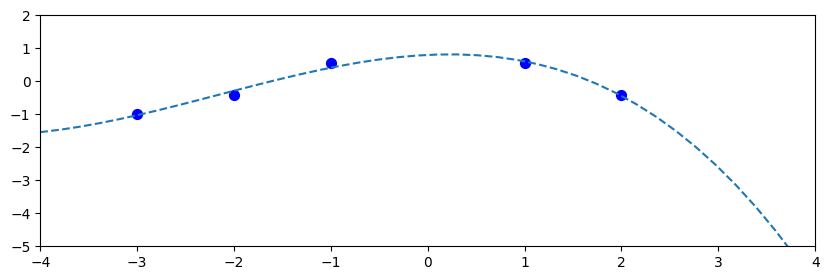

In [113]:
plt.figure(figsize = (10,3))
plt.scatter(x_train,y_train,color='blue',s=50)
plt.plot(x_test,y_pred_test, '--')
plt.xlim(-4,4)
plt.ylim(-5,2)

#### As we can see Linear regression has good intrapolation  but very poor extrapolation while GP can extrapolate well too if we use good kernels.

#### Let's try Gaussian Process on BCF dataset

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X, y = df_bcf.iloc[:, 3:].values, df_bcf.iloc[:, 2].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [120]:
kernel_ = [kernels.RationalQuadratic(alpha=0.5,length_scale=0.5)]
# kernel_ = [kernels.RBF(),kernels.RationalQuadratic(),kernels.DotProduct(sigma_0=1.0)**2,kernels.RationalQuadratic()*kernels.Matern(),kernels.Matern()]


Assuming no noise in data

##################################################
RationalQuadratic(alpha=0.5, length_scale=0.5)
##################################################
gp.kernel_ :  RationalQuadratic(alpha=0.00656, length_scale=0.00394)
0.755122822998383


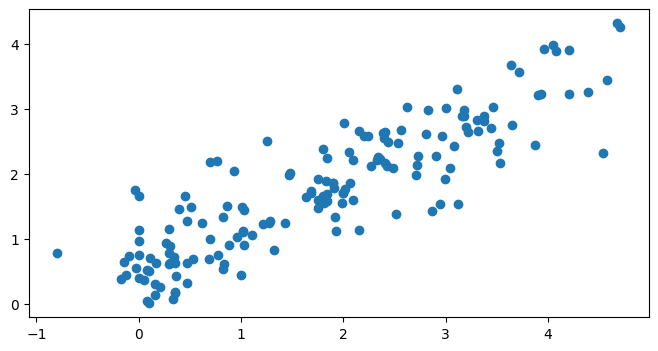

In [121]:
for kernel in kernel_:
  # implementation of Gaussian process
  gp = GaussianProcessRegressor(kernel = kernel)

  # defining test set
  x_test = X_test_std

  # prior sample/predictions
  m_prior, std_prior = gp.predict(x_test, return_std = True)
  prior_predictions = gp.sample_y(x_test,2)

  print('#'*50)
  print(kernel)
  print('#'*50)


  # defining training dataset
  x_train = X_train_std
  gp.fit(x_train,y_train)
  print("gp.kernel_ : " , gp.kernel_)
  # posterior predictions
  m_post, std_post = gp.predict(x_test,return_std=True)
  m_post = m_post.reshape(-1)
  post_predictions = np.squeeze(gp.sample_y(x_test,3))
  R2_score = R2(y_test, m_post)
  print( R2_score)
  plt.figure(figsize = (8,4))
  plt.scatter(y_test,m_post)

Assuming noise in the training data

##################################################
RationalQuadratic(alpha=0.671, length_scale=0.5)
##################################################


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


gp.kernel_ :  RationalQuadratic(alpha=0.00466, length_scale=0.00357)
0.7486154877879512


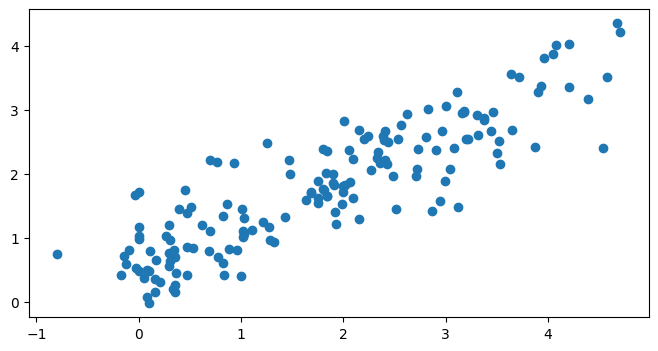

In [122]:
# defining training dataset
rng = np.random.RandomState(1)
noise_std=0.45
x_train = X_train_std
y_train_noise = y_train + rng.normal(loc=0.0,scale=noise_std,size=y_train.shape)
kernel_ = [kernels.RationalQuadratic(alpha=noise_std**0.5,length_scale=0.5)]
for kernel in kernel_:
  # implementation of Gaussian process
  gp = GaussianProcessRegressor(kernel = kernel)

  # defining test set
  x_test = X_test_std

  # prior sample/predictions
  m_prior, std_prior = gp.predict(x_test, return_std = True)
  prior_predictions = gp.sample_y(x_test,2)

  print('#'*50)
  print(kernel)
  print('#'*50)


  gp.fit(x_train,y_train_noise)
  print("gp.kernel_ : " , gp.kernel_)
  # posterior predictions
  m_post, std_post = gp.predict(x_test,return_std=True)
  m_post = m_post.reshape(-1)
  post_predictions = np.squeeze(gp.sample_y(x_test,3))
  R2_score = R2(y_test, m_post)
  print( R2_score)
  plt.figure(figsize = (8,4))
  plt.scatter(y_test,m_post)